# Выбор локации для скважины

## Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Цель проекта

Построить модель, чтобы понять где бурить новую скважину.

## Описание данных

Данные содержат 3 Датафрейма с информацией о компании.

## План работы

1. Загрузка и подготовка данных
2. Обучение и проверка модели
3. Подготовка к расчёту прибыли
4. Расчёт прибыли и рисков 
5. Вывод

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from phik.phik import phik_matrix
from sklearn.svm import SVR

## Загрузка и подготовка данных

In [2]:
#анализируем 1 набор данных
filepath = r"C:\Users\erofe\Downloads\geo_data_0.csv"
df_1 = pd.read_csv(filepath, sep=',')
#ищем дубликаты
print(df_1.duplicated().sum())
#выводим первые 10 строк таблицы
print(df_1.head(10))
#выводим информацию о таблице
print(df_1.info())

0
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
5  wX4Hy  0.969570  0.489775 -0.735383   64.741541
6  tL6pL  0.645075  0.530656  1.780266   49.055285
7  BYPU6 -0.400648  0.808337 -5.624670   72.943292
8  j9Oui  0.643105 -0.551583  2.372141  113.356160
9  OLuZU  2.173381  0.563698  9.441852  127.910945
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Non

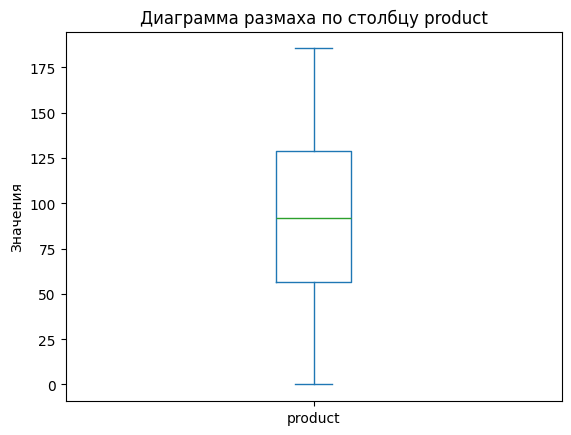

In [3]:
#строим диаграммы размаха для столбцов, где выбросы надо будет возможно удалять
df_1['product'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу product', ylabel = 'Значения')
plt.show()

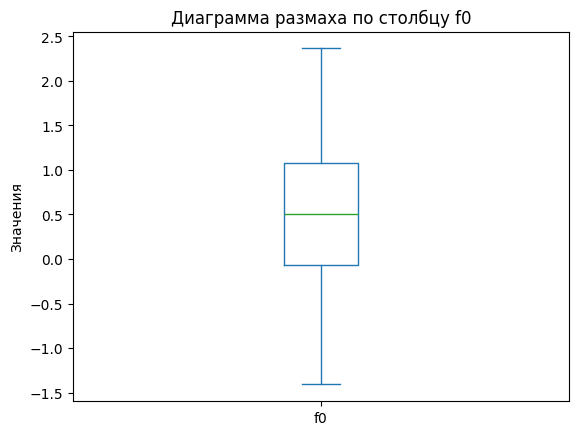

In [4]:
df_1['f0'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу f0', ylabel = 'Значения')
plt.show()

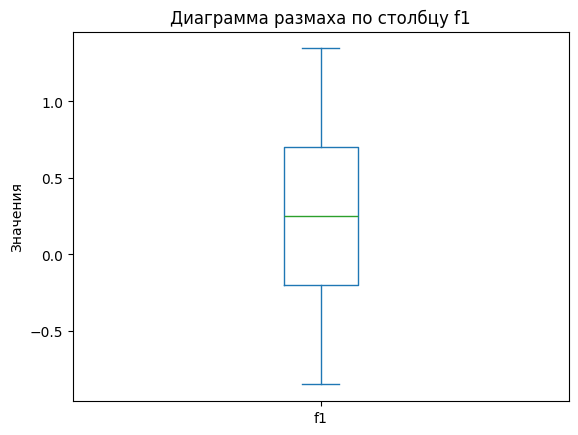

In [5]:
df_1['f1'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу f1', ylabel = 'Значения')
plt.show()

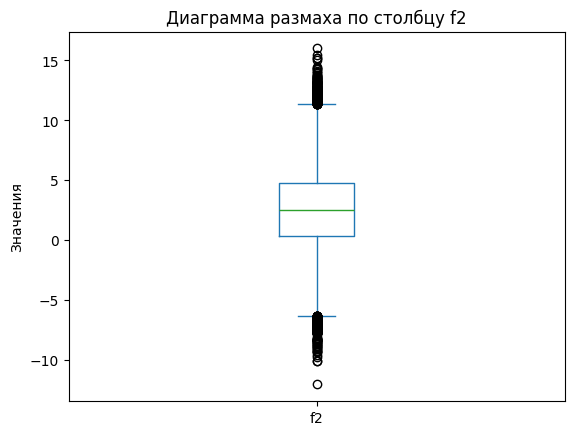

In [6]:
df_1['f2'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу f2', ylabel = 'Значения')
plt.show()

С данными все хорошо, есть аномальные значения в столбце f2, но удалять их не стоит.

In [7]:
#анализируем 2 набор данных
filepath = r"C:\Users\erofe\Downloads\geo_data_1.csv"
df_2 = pd.read_csv(filepath, sep=',')
#ищем дубликаты
print(df_2.duplicated().sum())
#выводим первые 10 строк таблицы
print(df_2.head(10))
#выводим информацию о таблице
print(df_2.info())

0
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
5  HHckp  -3.327590  -2.205276  3.003647   84.038886
6  h5Ujo -11.142655 -10.133399  4.002382  110.992147
7  muH9x   4.234715  -0.001354  2.004588   53.906522
8  YiRkx  13.355129  -0.332068  4.998647  134.766305
9  jG6Gi   1.069227 -11.025667  4.997844  137.945408
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
mem

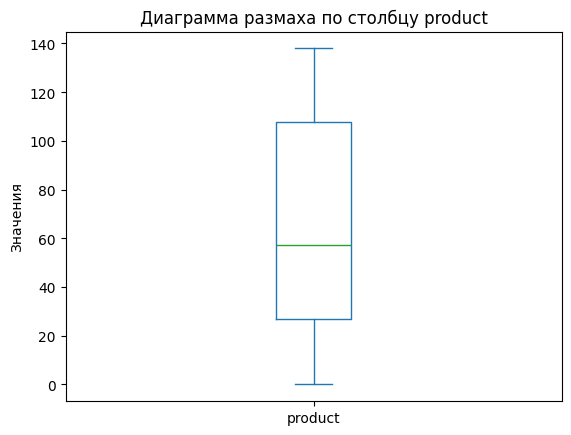

In [8]:
#строим диаграммы размаха для столбцов, где выбросы надо будет возможно удалять
df_2['product'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу product', ylabel = 'Значения')
plt.show()

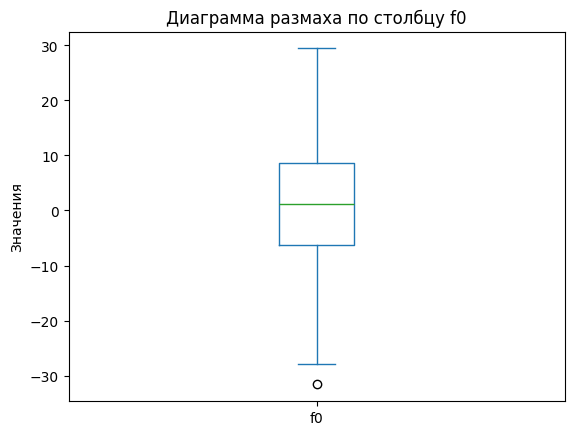

In [9]:
df_2['f0'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу f0', ylabel = 'Значения')
plt.show()

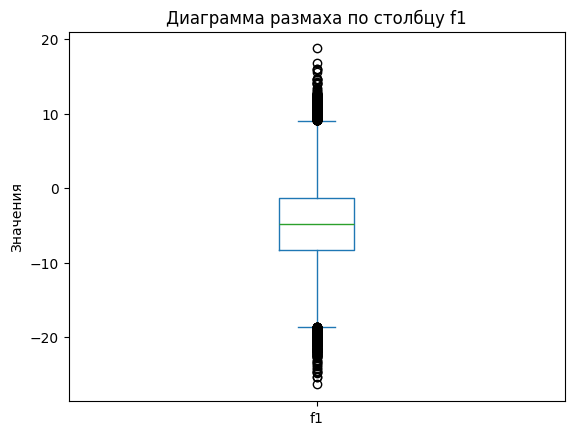

In [10]:
df_2['f1'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу f1', ylabel = 'Значения')
plt.show()

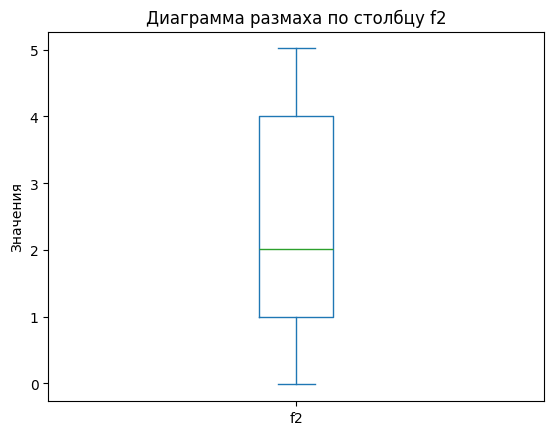

In [11]:
df_2['f2'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу f2', ylabel = 'Значения')
plt.show()

С данными все хорошо, есть аномальные значения в столбце f0 и f1, но удалять их не стоит.

In [12]:
#анализируем 2 набор данных
filepath = r"C:\Users\erofe\Downloads\geo_data_2.csv"
df_3 = pd.read_csv(filepath, sep=',')
#ищем дубликаты
print(df_3.duplicated().sum())
#выводим первые 10 строк таблицы
print(df_3.head(10))
#выводим информацию о таблице
print(df_3.info())

0
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
5  LzZXx -0.758092  0.710691  2.585887   90.222465
6  WBHRv -0.574891  0.317727  1.773745   45.641478
7  XO8fn -1.906649 -2.458350 -0.177097   72.480640
8  ybmQ5  1.776292 -0.279356  3.004156  106.616832
9  OilcN -1.214452 -0.439314  5.922514   52.954532
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Non

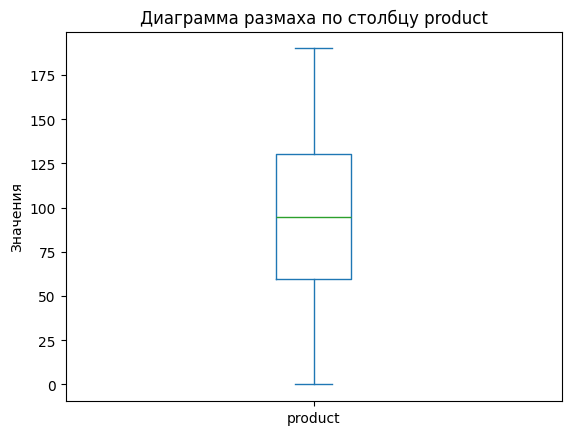

In [13]:
#строим диаграммы размаха для столбцов, где выбросы надо будет возможно удалять
df_3['product'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу product', ylabel = 'Значения')
plt.show()

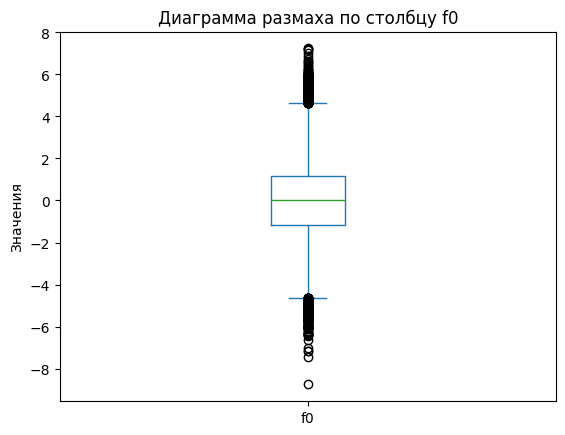

In [14]:
df_3['f0'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу f0', ylabel = 'Значения')
plt.show()

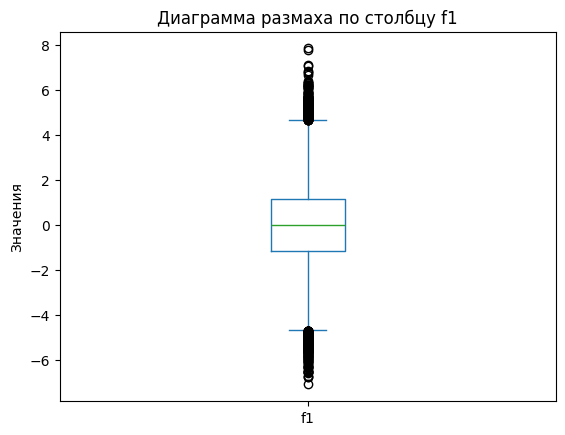

In [15]:
df_3['f1'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу f1', ylabel = 'Значения')
plt.show()

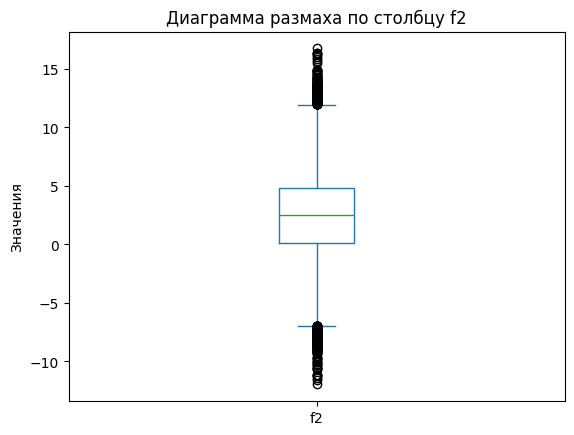

In [16]:
df_3['f2'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу f2', ylabel = 'Значения')
plt.show()

С данными все хорошо, есть аномальные значения в столбцx f0, f1, f2, но удалять их не стоит.

In [17]:
#Удалим столбец id, ведь он нам не нужен для анализа
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)
df_3 = df_3.drop(['id'], axis=1)

Вывод: была проведена загрузка и подготовка данных, данные в полном порядке.

## Обучение и проверка модели

In [18]:
# Разделяем данные на признаки и целевую переменную
X = df_1.drop(['product'], axis=1)
y = df_1['product']

# Разбиение данных на обучающую и валидационную выборки (в соотношении 75:25)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Определение количественных и категориальных признаков
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Создание трансформатора для количественных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Создание пайплайна предварительной обработки данных и поиска лучшей модели
models = {
    'LinearRegression': {'model': LinearRegression(), 'param_grid': {}}}


results = {}

for model_name, config in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    grid_search = GridSearchCV(pipeline, config['param_grid'], cv=5, scoring='neg_mean_squared_error')
    
    # Обучение на обучающей выборке
    grid_search.fit(X_train, y_train)
    
    # Вывод лучших параметров и лучшей модели
    print(f"{model_name}: Лучшие параметры - {grid_search.best_params_}")
    print(f"{model_name}: Лучшая модель - {grid_search.best_estimator_}")
    
    # Предсказания на валидационной выборке
    y_pred = grid_search.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"{model_name}: RMSE на валидационной выборке - {rmse}\n")
    
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_model': grid_search.best_estimator_,
        'RMSE': rmse
    }

for model_name, result in results.items():
    avg_predicted_stock = result['best_model'].predict(X_val).mean()
    print(f"{model_name}: Средний запас предсказанного сырья - {avg_predicted_stock}")
    
predict_1 = result['best_model'].predict(X_val)
predict_1 = pd.Series(predict_1)
real_1 = y_val
real_1 = pd.Series(real_1)
real_1 = real_1.reset_index(drop = True)

LinearRegression: Лучшие параметры - {}
LinearRegression: Лучшая модель - Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['f0', 'f1', 'f2'], dtype='object'))])),
                ('regressor', LinearRegression())])
LinearRegression: RMSE на валидационной выборке - 37.75660035026169

LinearRegression: Средний запас предсказанного сырья - 92.39879990657768


In [19]:
# Разделяем данные на признаки и целевую переменную
X = df_2.drop(['product'], axis=1)
y = df_2['product']

# Разбиение данных на обучающую и валидационную выборки (в соотношении 75:25)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Определение количественных и категориальных признаков
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Создание трансформатора для количественных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Создание пайплайна предварительной обработки данных и поиска лучшей модели
models = {
    'LinearRegression': {'model': LinearRegression(), 'param_grid': {}}}

results = {}

for model_name, config in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    grid_search = GridSearchCV(pipeline, config['param_grid'], cv=5, scoring='neg_mean_squared_error')
    
    # Обучение на обучающей выборке
    grid_search.fit(X_train, y_train)
    
    # Вывод лучших параметров и лучшей модели
    print(f"{model_name}: Лучшие параметры - {grid_search.best_params_}")
    print(f"{model_name}: Лучшая модель - {grid_search.best_estimator_}")
    
    # Предсказания на валидационной выборке
    y_pred = grid_search.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"{model_name}: RMSE на валидационной выборке - {rmse}\n")
    
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_model': grid_search.best_estimator_,
        'RMSE': rmse
    }

for model_name, result in results.items():
    avg_predicted_stock = result['best_model'].predict(X_val).mean()
    print(f"{model_name}: Средний запас предсказанного сырья - {avg_predicted_stock}")
    
predict_2 = result['best_model'].predict(X_val)
predict_2 = pd.Series(predict_2)
real_2 = y_val
real_2 = pd.Series(real_2)
real_2 = real_2.reset_index(drop = True)

LinearRegression: Лучшие параметры - {}
LinearRegression: Лучшая модель - Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['f0', 'f1', 'f2'], dtype='object'))])),
                ('regressor', LinearRegression())])
LinearRegression: RMSE на валидационной выборке - 0.8902801001028838

LinearRegression: Средний запас предсказанного сырья - 68.7128780391376


In [20]:
# Разделяем данные на признаки и целевую переменную
X = df_3.drop(['product'], axis=1)
y = df_3['product']

# Разбиение данных на обучающую и валидационную выборки (в соотношении 75:25)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Определение количественных и категориальных признаков
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Создание трансформатора для количественных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Создание пайплайна предварительной обработки данных и поиска лучшей модели
models = {
    'LinearRegression': {'model': LinearRegression(), 'param_grid': {}}
}

results = {}

for model_name, config in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    grid_search = GridSearchCV(pipeline, config['param_grid'], cv=5, scoring='neg_mean_squared_error')
    
    # Обучение на обучающей выборке
    grid_search.fit(X_train, y_train)
    
    # Вывод лучших параметров и лучшей модели
    print(f"{model_name}: Лучшие параметры - {grid_search.best_params_}")
    print(f"{model_name}: Лучшая модель - {grid_search.best_estimator_}")
    
    # Предсказания на валидационной выборке
    y_pred = grid_search.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"{model_name}: RMSE на валидационной выборке - {rmse}\n")
    
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_model': grid_search.best_estimator_,
        'RMSE': rmse
    }

for model_name, result in results.items():
    avg_predicted_stock = result['best_model'].predict(X_val).mean()
    print(f"{model_name}: Средний запас предсказанного сырья - {avg_predicted_stock}")
    
predict_3 = result['best_model'].predict(X_val)
predict_3 = pd.Series(predict_3)
real_3 = y_val
real_3 = pd.Series(real_3)
real_3 = real_3.reset_index(drop = True)

LinearRegression: Лучшие параметры - {}
LinearRegression: Лучшая модель - Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['f0', 'f1', 'f2'], dtype='object'))])),
                ('regressor', LinearRegression())])
LinearRegression: RMSE на валидационной выборке - 40.14587231134218

LinearRegression: Средний запас предсказанного сырья - 94.77102387765939


Вывод: Модель достаточно точно предсказала запасы нефти во втором регионе (с наименьшим RMSE - 0.89), а в первом и третьем значения также близки к фактическим данным. Однако утрата данных из второго региона могла существенно повлиять на обучение модели, возможно, приведя к переобучению.

Учитывая утрату данных и относительно низкие средние запасы на месторождение, рассматривать второй регион как потенциально прибыльный, вероятно, нецелесообразно.

Нам нужно более внимательно оценить риски и потенциальную прибыльность всех регионов, но для принятия окончательного решения сконцентрируемся на первом и третьем регионах.

## Подготовка к расчёту прибыли

In [21]:
total_budget = 10000000000  # Общий бюджет
selected_wells = 500  # Выбранные скважины
best_wells = 200  # Лучшие скважины
barrel_price = 450000  # Цена за баррель нефти

In [22]:
average_profit_per_point = total_budget / best_wells
print('Средняя прибыль на выбранную точку -', average_profit_per_point, 'руб.')

average_barrels_per_point = average_profit_per_point  / barrel_price
print('Средний объем нефти на точку -',average_barrels_per_point, 'тыс. барелей')

average_barrels = total_budget / barrel_price
print('Средний объем нефти на регион -',average_barrels, 'тыс. барелей')

Средняя прибыль на выбранную точку - 50000000.0 руб.
Средний объем нефти на точку - 111.11111111111111 тыс. барелей
Средний объем нефти на регион - 22222.222222222223 тыс. барелей


In [23]:
print('Средний объем добычи нефти на одну скважину в регионе 1:', df_1['product'].mean())
print('Средний объем добычи нефти на одну скважину в регионе 2:', df_2['product'].mean())
print('Средний объем добычи нефти на одну скважину в регионе 3:', df_3['product'].mean())

Средний объем добычи нефти на одну скважину в регионе 1: 92.50000000000001
Средний объем добычи нефти на одну скважину в регионе 2: 68.82500000000002
Средний объем добычи нефти на одну скважину в регионе 3: 95.00000000000004


In [24]:
#Создадим функцию для расчёта прибыли
def revenue(target, probabilities):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:200]
    net =selected.sum() * barrel_price - total_budget
    return net

Была подготовлена средняя оценка прибыли за скважину и средний объем на скважину и создана функция по расчету прибыли. Данные по средним фактическим запасам указывают на высокую вероятность окупаемости затрат для первого и третьего регионов. Разброс значений вокруг среднего объёма в 92.5 и 95 свидетельствует о наличии значительного числа скважин с запасами, превышающими средние показатели.

## Расчёт прибыли и рисков 

In [25]:
print(revenue(real_1, predict_1)) 
print(revenue(real_2, predict_2)) 
print(revenue(real_3, predict_3)) 

3359141114.462179
2415086696.681511
2598571759.374111


In [26]:
state_0 = np.random.RandomState(12345)

values_0 = []
for i in range(1000):
    target_subsample = real_1.sample(n=500, replace=True, random_state=state_0)
    probs_sample = predict_1[target_subsample.index]
    values_0.append(revenue(target_subsample, probs_sample))

values_0 = pd.Series(values_0)
values_0.describe()

count    1.000000e+03
mean     4.359338e+08
std      2.767344e+08
min     -5.054086e+08
25%      2.623847e+08
50%      4.379881e+08
75%      6.305342e+08
max      1.395802e+09
dtype: float64

In [27]:
values_1 = []
for i in range(1000):
    target_subsample = real_2.sample(n=500, replace=True, random_state=state_0)
    probs_sample = predict_2[target_subsample.index]
    values_1.append(revenue(target_subsample, probs_sample))

values_1 = pd.Series(values_1)
values_1.describe()

count    1.000000e+03
mean     4.985690e+08
std      2.142050e+08
min     -2.264780e+08
25%      3.635807e+08
50%      5.001715e+08
75%      6.303869e+08
max      1.146894e+09
dtype: float64

In [28]:
values_2 = []
for i in range(1000):
    target_subsample = real_3.sample(n=500, replace=True, random_state=state_0)
    probs_sample = predict_3[target_subsample.index]
    values_2.append(revenue(target_subsample, probs_sample))

values_2 = pd.Series(values_2)
values_2.describe()

count    1.000000e+03
mean     4.126729e+08
std      2.864188e+08
min     -4.364396e+08
25%      2.298477e+08
50%      4.021349e+08
75%      6.126680e+08
max      1.368313e+09
dtype: float64

In [29]:
#Строим необходимые функции
def calculate_confidence_interval(profits):
    lower_bound = np.percentile(profits, 2.5)
    upper_bound = np.percentile(profits, 97.5)
    return lower_bound, upper_bound

def calculate_negative_profit_probability(profits):
    negative_profits = np.sum(profits < 0) / len(profits)
    return negative_profits

# Средняя прибыль
mean_profit_1 = values_0.mean()
mean_profit_2 = values_1.mean()
mean_profit_3 = values_2.mean()

# Доверительные интервалы
conf_interval_1 = calculate_confidence_interval(values_0)
conf_interval_2 = calculate_confidence_interval(values_1)
conf_interval_3 = calculate_confidence_interval(values_2)

# Риск убытков
negative_prob_1 = calculate_negative_profit_probability(values_0)
negative_prob_2 = calculate_negative_profit_probability(values_1)
negative_prob_3 = calculate_negative_profit_probability(values_2)

print("Регион 0:")
print(f"Средняя прибыль: {mean_profit_1:.2f} рублей")
print(f"95%-й доверительный интервал: от {conf_interval_1[0]:.2f} до {conf_interval_1[1]:.2f} рублей")
print(f"Риск убытков: {negative_prob_1 * 100:.2f}%")
print("\nРегион 1:")
print(f"Средняя прибыль: {mean_profit_2:.2f} рублей")
print(f"95%-й доверительный интервал: от {conf_interval_2[0]:.2f} до {conf_interval_2[1]:.2f} рублей")
print(f"Риск убытков: {negative_prob_2 * 100:.2f}%")
print("\nРегион 2:")
print(f"Средняя прибыль: {mean_profit_3:.2f} рублей")
print(f"95%-й доверительный интервал: от {conf_interval_3[0]:.2f} до {conf_interval_3[1]:.2f} рублей")
print(f"Риск убытков: {negative_prob_3 * 100:.2f}%")

Регион 0:
Средняя прибыль: 435933772.14 рублей
95%-й доверительный интервал: от -116231612.78 до 966504180.71 рублей
Риск убытков: 6.10%

Регион 1:
Средняя прибыль: 498569016.92 рублей
95%-й доверительный интервал: от 75315573.09 до 911503695.02 рублей
Риск убытков: 1.00%

Регион 2:
Средняя прибыль: 412672898.99 рублей
95%-й доверительный интервал: от -158939515.76 до 978191201.70 рублей
Риск убытков: 7.00%


Все 3 региона являются достаточно прибыльными, но я бы советовал выбрать 2 регион, ведь он самый прибыльный и менее рисковый.

## Вывод

Проект включал в себя следующие этапы: изучение данных, подготовка их для моделирования, обучение моделей для трех регионов, разработка функции для расчета прибыли в каждом регионе, оценка прибыли и рисков для каждого региона и объяснение выбора оптимального региона.

Из всех регионов, второй оказался одним из наилучших, хотя и все остальные регионы являются очень прибыльными, но риски слишком велики для рассмотрения вложений туда.